# Evaluación de resultados

Poner a prueba el modelo entrenado y a traves de diferentes metodos de evaluación identificar la exactitud del modelo para predecir valores nuevos correctamente.

Se evaluará tanto numerica como visualmente.

In [1]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones auxiliares

Se hará uso de las funciones que se han venido trabajando para:

1. Cargar el dataset en formato arff a DF de Pandas.
2. Dividir el conjunto de datos en 3 subconjuntos (train, test, validation)
3. Transformer para transformar categoricos a numericos
4. Pipeline para rellenar nulos con mediana y escalar valores distantes
5. Transformer general para aplicar el pipeline y transformer juntos a todo el conjunto en una sola llamada.

In [2]:
# Funcion para cargar dataset en formato arff a un df de Pandas
def load_kdd_dataset(data_path):
    """Lectura del conjunto de datos NSL-KDD."""
    with open(data_path, 'r') as train_set:
        dataset = arff.load(train_set)
    attributes = [attr[0] for attr in dataset["attributes"]]
    return pd.DataFrame(dataset["data"], columns=attributes)

In [3]:
# Función que realiza el particionado del DF
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):

    # Strat solo si le pasamos la columa a dispersar
    strat = df[stratify] if stratify else None 
    
    train_set, test_set = train_test_split(
        df,
        test_size=0.4,
        random_state=rstate, # Semilla de generación aleatoria única
        shuffle=shuffle, # Si se hace o no un shuffle
        stratify=strat # Columna a dispersar si la hay
    )

    # Se repite el proceso para obtener el validation_set
    strat = test_set[stratify] if stratify else None
    
    val_set, test_set = train_test_split(
        test_set,
        test_size=0.5,
        random_state=rstate,
        shuffle=shuffle,
        stratify=strat
    )
    
    return (train_set, val_set, test_set)

In [4]:
# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [30]:
# Transormador para transformar columnas categoricas a numericas
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._oh = OneHotEncoder()
        self._columns = None
        
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh.toarray(), 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [27]:
# Transofrmador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
        
    def fit(self, X, y=None):
        # Separar numericas y categoricas
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        # Aplicar pipeline para numericas y columntransformer para categoricas
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        # Preparar los valores para su transformacion
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self

    # Aplicar las transformaciones y retornar un solo dataset restante limpio y listo para entrenar
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

## Leer el conjunto de datos

In [8]:
df = load_kdd_dataset("../datasets/NSL-KDD/KDDTrain+.arff")
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


## Dividir el conjunto de datos

In [9]:
# Division del conjunto en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(df)

In [10]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 75583
Longitud del Validation Set: 25195
Longitud del Test Set: 25195


#### Para cada uno de los subconjuntos de datos separamos las caracteristicas de entrada y los valores etiqueta

In [11]:
# Conjunto de datos general
X_df = df.drop("class", axis=1)
y_df = df["class"].copy()

In [12]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("class", axis=1)
y_train = train_set["class"].copy()

In [13]:
# Conjunto de datos de validación
X_val = val_set.drop("class", axis=1)
y_val = val_set["class"].copy()

In [14]:
# Conjunto de datos de pruebas
X_test = test_set.drop("class", axis=1)
y_test = test_set["class"].copy()

## Preparar el conjunto de datos

In [28]:
# Instanciamos nuestro transformador personalizado que limpiara los dataset
data_preparer = DataFramePreparer()

In [35]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles antes de poder transformar los subconjuntos
data_preparer.fit(X_df)

DataFramePreparer()

In [36]:
# Limpiamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)

In [37]:
X_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
98320,0.0,icmp,ecr_i,SF,1032.0,0.0,0,0.0,0.0,0.0,...,210.0,65.0,0.31,0.01,0.31,0.00,0.0,0.0,0.0,0.0
8590,0.0,tcp,smtp,SF,1762.0,331.0,0,0.0,0.0,0.0,...,30.0,122.0,0.73,0.07,0.03,0.02,0.0,0.0,0.0,0.0
91385,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,126.0,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0
54349,0.0,tcp,csnet_ns,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,18.0,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0
69568,0.0,tcp,smtp,SF,1518.0,342.0,0,0.0,0.0,0.0,...,83.0,125.0,0.66,0.05,0.01,0.02,0.0,0.0,0.0,0.0


In [38]:
X_train_prep.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
98320,0.0,3.579710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8590,0.0,6.224638,0.641473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
91385,0.0,-0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
54349,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
69568,0.0,5.340580,0.662791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [39]:
# Limpiamos el subconjunto de datos de validacion
X_val_prep = data_preparer.transform(X_val)

## Entrenar un modelo con Regresión Logística

El modelo deberá ser capaz de predecir si un tráfico de red es normal o anómalo

In [40]:
# Entrenar un algoritmo basado en regresión logística
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000)
model.fit(X_train_prep, y_train)

/home/ljmor/anaconda3/envs/curso_deep_learning/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

## Predecir con nuestro subconjunto de validacion

In [41]:
y_pred = model.predict(X_val_prep)

## 1. Matriz de confusión

Permitirá visualizar en numero de verdaderos y falsos positivos-negativos respectivamente

In [53]:
from sklearn.metrics import confusion_matrix
conf_met = confusion_matrix(y_val, y_pred, labels=['anomaly', 'normal'])
conf_met

array([[11419,   455],
       [  259, 13062]])

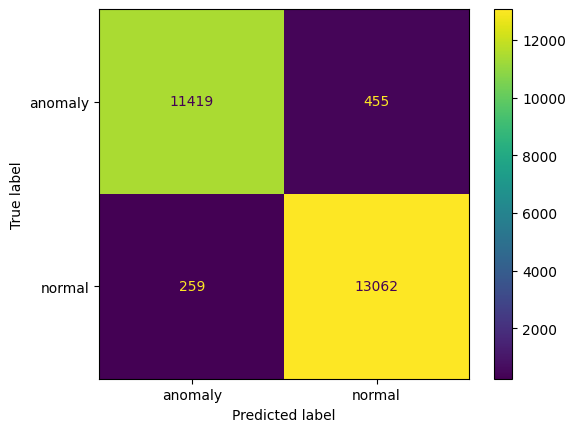

In [54]:
# Representacion gráfica de la matriz de confusion
from sklearn.metrics import ConfusionMatrixDisplay

conf_disp = ConfusionMatrixDisplay(conf_met, display_labels=['anomaly', 'normal'])
conf_disp.plot()

De la gráfica generada podemos determinar que el modelo pudo predecir 11419 valores que eran anomalos como anomalos y 455 que eran anomalos como normales.

Por otra parte predijo 13062 valores que eran normales como normales y 259 que eran normales como anomalos.

Por ende podemos concluir que que el modelo ha logrado predecir valores completamente nuevos con un nivel bastante elevado de **éxito**

## Métricas derivada de la matriz de confusión

In [55]:
# Valor de precision
from sklearn.metrics import precision_score

p_score = precision_score(y_val, y_pred, pos_label='anomaly')
print(f'Porcentaje de precisión del {p_score * 100}%')

Porcentaje de precisión del 97.78215447850658%


In [56]:
# Valor del recall o exhaustividad
from sklearn.metrics import recall_score

r_score = recall_score(y_val, y_pred, pos_label='anomaly')
print(f'Porcentaje de recall del {r_score * 100}%')

Porcentaje de recall del 96.1680983661782%


Siempre se deben verificar ambas puesto que si solo nos quedamos con una solo tendremos una evaluacion parcial del modelo

In [57]:
# Valor del f1 Score (Fusion de precision y el recall) el valor mas general y que mas 
# vision nos puede dar de el puntaje de excatitud de nuestro modelo
from sklearn.metrics import f1_score

f_score = f1_score(y_val, y_pred, pos_label='anomaly')
print(f'Porcentaje de exactitud general del {f_score * 100}%')

Porcentaje de exactitud general del 96.96841032608695%


## 3. Curvas ROC y PR

Gráficas que permiten la visualización de el comportamiento de nuestro modelo

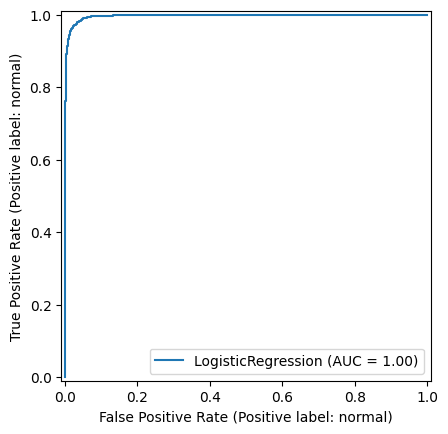

In [67]:
# Curva ROC (Mientras mas arriba y a la izquierda este la curva más exacto sera el modelo)
from sklearn.metrics import RocCurveDisplay

roc_plot = RocCurveDisplay.from_estimator(model, X_val_prep, y_val)

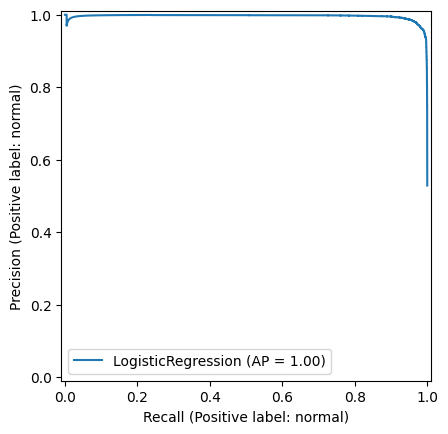

In [69]:
# Curva de PR (Mientras mas arriba y a la derecha este la curva más exacto sera el modelo)
from sklearn.metrics import PrecisionRecallDisplay

pr_plot = PrecisionRecallDisplay.from_estimator(model, X_val_prep, y_val)